### オートエンコーダ
オートエンコーダはエンコーダとデコーダの2つの部分からなる。  
1. エンコーダネットワーク  
　　訓練済みのエンコーダを使って、最初のデータ表現、例えば画像$x$を入力とすれば、その次元を$\cilda{y}$を$\cilda{z}$に減らす  
2. 潜在空間($z$)  
　　ネットワークを訓練するにあたって、潜在空間に何らかの意味が形成される  
　　通常は入力より小さな次元で、中間ステップとして動作  
3. デコーダネットワーク  
　　元の表現と同じものを、元の次元で再構築する  
　　このステップにより$z$は$x^*$に変換される  
  
オートエンコーダの訓練は以下のように行われる。
1. 画像$x$を取り出しオートエンコーダに入力する  
2. $x^*$が出力される。これは再構成された画像である。  
3. 再構成誤差を計算する。これは$x$と$x^*$の差である。  
　これは$x$と$x^*$の距離(例えばMAE)として計算され、明示的な目的関数($|x-x^*|$)が定義され、勾配降下法により最適化可能となる  
   
### 変分オートエンコーダ  (VAE)
変分オートエンコーダでは、潜在空間は学習された平均値と標準偏差を持つ正規分布として表現される。  
まずエンコーダにより入力から平均ベクトル$\mu$と分散ベクトル$\sigma$を求める。  
これらを基に潜在変数$z$が確率的にサンプリングされ、$z$からデコーダにより元のデータが再現される。  
この$z$を調整することで連続的に変化するデータを生成できる。  
#### 潜在変数のサンプリング
潜在変数とは入力の特徴をエンコーダを使ってより低い次元に減らしたものである。  
平均値$\mu$と標準偏差$\sigma$を出力し、これらを使った正規分布により潜在変数$z$をサンプリングする。
#### Reparametrization Trick
サンプリングする処理はそのままではバックプロパゲーションを適用できない。  
そこで、Reparametrization Trickという方法では、平均値0,標準偏差1の正規分布からサンプリングされた$\epsilon$を使って以下のように潜在変数を定義する。
$$
z=\mu+\epsilon\sigma
$$
この式を利用することで、バックプロパゲーションが適用できるようになる。
#### 誤差
「潜在変数がどれだけ発散しているか」(正則化項)$E_{reg}$と「出力が入力からどれだけずれているかを表す再構成誤差」$E_{rec}$を合わせてVAEの誤差とする。
$$
E=E_{rec}+E_{reg}
$$
##### 再構成誤差
$$
E_{rec}=\frac{1}{h}\sum_{i=1}^h\sum_{j=1}^m(-x_{ij}\log y_{ij}-(1-x_{ij})\log (1-y_{ij}))
$$
$x_{ij}$はVAEの入力、$y_{ij}$はVAEの出力、$h$はバッチサイズ、$m$は入力層、出力層のニューロン数となる。  
ここで、$\Sigma$を省略して以下の通りに表す。
$$
e_{rec}=-x\log y-(1-x)\log (1-y)
$$
この誤差は「交差エントロピー」と呼ばれる。
##### 正則化項
$$
E_{rec}=\frac{1}{h}\sum_{i=1}^h\sum_{k=1}^n-\frac{1}{2}(1+\log\sigma_{ik}^2-\mu_{ik}^2-\sigma_{ik}^2)
$$
$h$はバッチサイズ、$n$は潜在変数の数、$\sigma_{ij}$は標準偏差、$\mu_{ij}$は平均値である。  
$\Sigma$を省略して以下の通りに表す。
$$
e_{rec}=-\frac{1}{2}(1+\log\sigma^2-\mu^2-\sigma^2)
$$


#### 実装(オートエンコーダ)

In [3]:
import numpy as np

img_size = 8
n_in_out = img_size * img_size
n_mid = 16

In [6]:
import numpy as np

class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self,grad_y):
        delta = grad_y * np.where(self.u <=0 , 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))
    
    def backward(self, t):
        delta = (self.y-t) * self.y * (1-self.y)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

In [7]:
def forward_propagation(x_mb):
    middle_layer.forward(x_mb)
    output_layer.forward(middle_layer.y)

def backpropagation(t_mb):
    output_layer.backward(t_mb)
    middle_layer.backward(output_layer.grad_x)

def update_params():
    output_layer.update(eta)
    middle_layer.update(eta)

Epoch:1/41 Error:3672.5388281926207
Epoch:5/41 Error:1540.5131847455912
Epoch:9/41 Error:1205.5238954290949
Epoch:13/41 Error:1091.9993962884537
Epoch:17/41 Error:1011.2295652433208
Epoch:21/41 Error:948.9348007792258
Epoch:25/41 Error:918.6886037479925
Epoch:29/41 Error:898.8043769513285
Epoch:33/41 Error:883.4977164522094
Epoch:37/41 Error:863.1531399274033
Epoch:41/41 Error:867.6716305230465


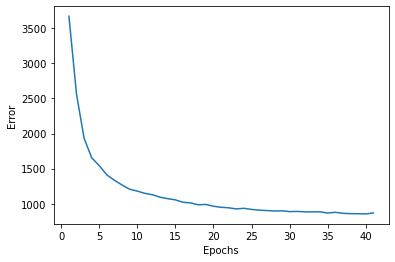

In [14]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 15

def get_error(y, t):
    return 1.0/2.0*np.sum(np.square(y - t))

img_size = 8
n_in_out = img_size * img_size
n_mid = 16

eta = 0.01
epochs = 41
batch_size = 32
interval = 4

middle_layer = MiddleLayer(n_in_out, n_mid)
output_layer = OutputLayer(n_mid, n_in_out)

error_record = []
n_batch = len(x_train) // batch_size
for i in range(epochs):
    
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        
        forward_propagation(x_mb)
        backpropagation(x_mb)
        
        update_params()
    
    forward_propagation(x_train)
    error = get_error(output_layer.y, x_train)
    error_record.append(error)
    
    if i%interval == 0:
        print("Epoch:"+str(i+1)+'/'+str(epochs), "Error:"+str(error))

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

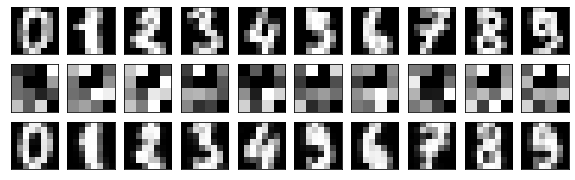

In [17]:
n_img = 10
middle_layer.forward(x_train[:n_img])
output_layer.forward(middle_layer.y)

plt.figure(figsize=(10, 3))
for i in range(n_img):
    
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_train[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(middle_layer.y[i].reshape(4, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i+1+2*n_img)
    plt.imshow(output_layer.y[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### pytorch
ネットワークの最終層にSigmoid関数を入れるため、損失関数はSigmoid関数の計算を省いたnn.BCELOSS()を使用する。

In [64]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [90]:
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 15
x_train = x_train.reshape(-1, 1, 64)
y = digits_data.target

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float64)

train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)

(1797, 1, 64)


In [100]:
class AutoEncoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(64, 16)
        self.l2 = nn.Linear(16, 64)
    
    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        y = torch.sigmoid(h)
        
        return y

In [121]:
device = None

model = AutoEncoder(device=device).to(device)
criterion = nn.BCELoss()
optimizer = optimizers.Adam(model.parameters())

In [122]:
epochs = 40
train_loss_record = []
for epoch in range(epochs):
    train_loss = 0.
    for (x, _) in train_dataloader:
        x = x.to(device)
        model.train()
        preds = model(x)
        loss = criterion(preds, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_loss_record.append(train_loss)
    
    if epoch%4 == 0:
        print("Epoch: {}, Loss: {:3f}".format(epoch+1, train_loss))

Epoch: 1, Loss: 0.653263
Epoch: 5, Loss: 0.378455
Epoch: 9, Loss: 0.312652
Epoch: 13, Loss: 0.289667
Epoch: 17, Loss: 0.277918
Epoch: 21, Loss: 0.268892
Epoch: 25, Loss: 0.259634
Epoch: 29, Loss: 0.251854
Epoch: 33, Loss: 0.245359
Epoch: 37, Loss: 0.240528


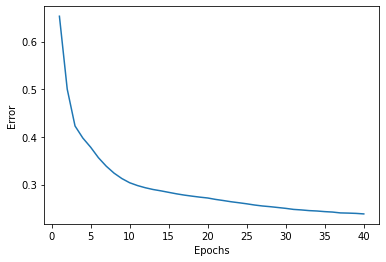

In [123]:
plt.plot(range(1, len(train_loss_record)+1), train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

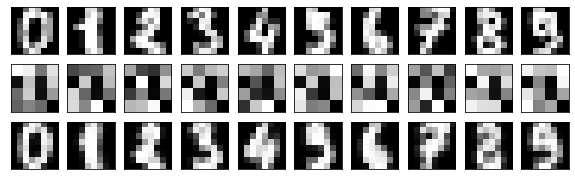

In [124]:
n_img = 10

x = x_train[:n_img]
mid_out = model.l1(x)
out = model(x)

plt.figure(figsize=(10, 3))
for i in range(n_img):
    
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_train[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(mid_out[i].reshape(4, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i+1+2*n_img)
    plt.imshow(out[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [125]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense

In [527]:
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 15
y = digits_data.target

In [179]:
input_shape=x_train.shape[1:]
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=input_shape, name='fc1'))
model.add(Dense(64, activation='softmax', name='fc2'))

In [180]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                1040      
_________________________________________________________________
fc2 (Dense)                  (None, 64)                1088      
Total params: 2,128
Trainable params: 2,128
Non-trainable params: 0
_________________________________________________________________


In [181]:
model.compile(optimizer='adam',
              loss='binary_crossentropy')

In [182]:
history = model.fit(x_train, x_train,
                    epochs=100,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(x_train, x_train))

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 1.372 - ETA: 0s - loss: 1.351 - 1s 9ms/step - loss: 1.3432 - val_loss: 1.2856
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 1.302 - ETA: 0s - loss: 1.280 - ETA: 0s - loss: 1.265 - ETA: 0s - loss: 1.254 - ETA: 0s - loss: 1.247 - 0s 8ms/step - loss: 1.2445 - val_loss: 1.2178
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 1.218 - ETA: 0s - loss: 1.213 - ETA: 0s - loss: 1.210 - ETA: 0s - loss: 1.210 - ETA: 0s - loss: 1.207 - ETA: 0s - loss: 1.206 - 0s 8ms/step - loss: 1.2070 - val_loss: 1.1971
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 1.211 - ETA: 0s - loss: 1.189 - ETA: 0s - loss: 1.189 - ETA: 0s - loss: 1.190 - ETA: 0s - loss: 1.190 - 0s 8ms/step - loss: 1.1899 - val_loss: 1.1821
Epoch 5/100
57/57 [==============================] - ETA: 0s - loss: 1.174 - ETA: 0s - loss: 1.182 - ETA: 0s - loss: 1.178 - ETA: 0s - loss: 1.175 - ETA: 0s - loss: 1.175 -

57/57 [==============================] - ETA: 0s - loss: 1.080 - ETA: 0s - loss: 1.119 - ETA: 0s - loss: 1.112 - 0s 4ms/step - loss: 1.1149 - val_loss: 1.1147
Epoch 81/100
57/57 [==============================] - ETA: 0s - loss: 1.122 - ETA: 0s - loss: 1.115 - ETA: 0s - loss: 1.115 - 0s 4ms/step - loss: 1.1149 - val_loss: 1.1148
Epoch 82/100
57/57 [==============================] - ETA: 0s - loss: 1.128 - ETA: 0s - loss: 1.116 - ETA: 0s - loss: 1.115 - ETA: 0s - loss: 1.114 - 0s 5ms/step - loss: 1.1149 - val_loss: 1.1148
Epoch 83/100
57/57 [==============================] - ETA: 0s - loss: 1.110 - ETA: 0s - loss: 1.119 - ETA: 0s - loss: 1.124 - ETA: 0s - loss: 1.116 - ETA: 0s - loss: 1.116 - ETA: 0s - loss: 1.114 - 0s 7ms/step - loss: 1.1148 - val_loss: 1.1147
Epoch 84/100
57/57 [==============================] - ETA: 0s - loss: 1.111 - ETA: 0s - loss: 1.114 - ETA: 0s - loss: 1.111 - ETA: 0s - loss: 1.114 - 0s 6ms/step - loss: 1.1148 - val_loss: 1.1146
Epoch 85/100
57/57 [=============

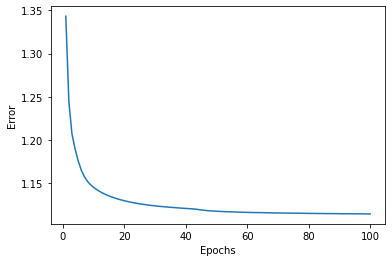

In [183]:
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

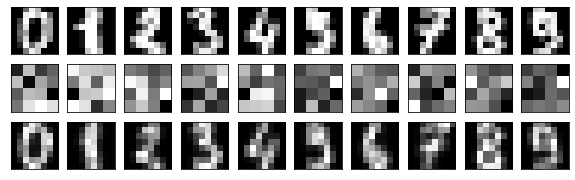

In [185]:
n_img = 10

x = np.float64(x_train[:n_img])
mid_out = np.array(model.layers[0](x))
out = np.array(model(x))

plt.figure(figsize=(10, 3))
for i in range(n_img):
    
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_train[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(mid_out[i].reshape(4, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i+1+2*n_img)
    plt.imshow(out[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### 実装(VAE)
#### 平均値、標準偏差を出力する層
標準偏差に関しては層の出力を標準偏差の2乗(分散)の対数を表すこととする。

In [23]:
class ParamsLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u
    
    def backward(self, grad_y):
        delta = grad_y
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#### サンプリング層
順伝搬はReparametrization Trickの式
$$
z=\mu+\epsilon\sigma
$$
に基づいて行われる。これを書き換えると、
$$
z=\mu+\epsilon\exp\frac{\phi}{2}
$$
となる。  
逆伝播を考えるため、誤差を以下の形で表す。
$$
\begin{align}
E&=E_{rec}+E_{reg}\\
E_{rec}&=\sum_{i=1}^h\sum_{j=1}^m(-x_{ij}\log y_{ij}-(1-x_{ij})\log (1-y_{ij}))\\
E_{reg}&=\sum_{i=1}^h\sum_{j=1}^m-\frac{1}{2}(1+\log\sigma_{ik}^2-\mu_{ik}^2-\sigma_{ik}^2)\\
&=\sum_{i=1}^h\sum_{j=1}^m-\frac{1}{2}(1+\phi_{ik}-\mu_{ik}^2-\exp\phi_{ik})
\end{align}
$$
$\mu$での微分は次のようになる。
$$
\begin{align}
\frac{\partial E}{\partial \mu}&=\frac{\partial}{\partial \mu}(E_{rec}+E_{reg})\\
&=\frac{\partial E_{rec}}{\partial z}\frac{\partial z}{\partial \mu}+\frac{\partial E_{reg}}{\partial \mu}\\
&=\frac{\partial E_{rec}}{\partial z}+\mu
\end{align}
$$
$\frac{\partial E_{rec}}{\partial z}$はデコーダからの逆伝播で得ることができる。  
$\phi$による微分は次のようになる。
$$
\begin{align}
\frac{\partial E}{\partial \phi}&=\frac{\partial}{\partial \phi}(E_{rec}+E_{reg})\\
&=\frac{\partial E_{rec}}{\partial z}\frac{\partial z}{\partial \phi}+\frac{\partial E_{reg}}{\partial \phi}\\
&=\frac{\partial E_{rec}}{\partial z}\frac{\epsilon}{2}\exp\frac{\phi}{2}-\frac{1}{2}(1-\exp\phi)
\end{align}
$$

In [20]:
class LatentLayer:
    def forward(self, mu, log_var):
        self.mu = mu
        self.log_var = log_var
        
        self.epsilon = np.random.randn(*log_var.shape)
        self.z = mu + self.epsilon*np.exp(log_var/2)
    
    def backward(self, grad_z):
        self.grad_mu = grad_z + self.mu
        self.grad_log_var = grad_z*self.epsilon/2*np.exp(self.log_var/2)-0.5*(1-np.exp(self.log_var))

#### 出力層
逆伝播では、
$$
\begin{align}
\delta&=\frac{\partial E}{\partial u}\\
&=\frac{\partial E}{\partial y}\frac{\partial y}{\partial u}\\
&=\frac{\partial}{\partial y}(E_{rec}+E_{reg})y(1-y)\\
&=(-\frac{t}{y}+\frac{1-t}{1-y})y(1-y)\\
&=-t(1-y)+(1-t)y\\
&=y-t
\end{align}
$$
と計算できる。

In [ ]:
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self,grad_y):
        delta = grad_y * np.where(self.u <=0 , 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

In [33]:
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))
    
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

In [36]:
def forward_propagation(x_mb):
    middle_layer_enc.forward(x_mb)
    mu_layer.forward(middle_layer_enc.y)
    log_var_layer.forward(middle_layer_enc.y)
    z_layer.forward(mu_layer.y, log_var_layer.y)

    middle_layer_dec.forward(z_layer.z)
    output_layer.forward(middle_layer_dec.y)

def backpropagation(t_mb):
    output_layer.backward(t_mb)
    middle_layer_dec.backward(output_layer.grad_x)
    
    z_layer.backward(middle_layer_dec.grad_x)
    log_var_layer.backward(z_layer.grad_log_var)
    mu_layer.backward(z_layer.grad_mu)
    middle_layer_enc.backward(mu_layer.grad_x+log_var_layer.grad_x)

def update_params():
    middle_layer_enc.update(eta)
    mu_layer.update(eta)
    log_var_layer.update(eta)
    
    middle_layer_dec.update(eta)
    output_layer.update(eta)

Epoch: 0 Rec_error: 27.613396149054633 Reg_error: 2.5025946910998496 Total_error: 30.11599084015448
Epoch: 20 Rec_error: 23.749381429968814 Reg_error: 2.826401436302149 Total_error: 26.575782866270963
Epoch: 40 Rec_error: 22.560515268506272 Reg_error: 4.169104566703853 Total_error: 26.729619835210123
Epoch: 60 Rec_error: 22.14799881862495 Reg_error: 4.335368323879357 Total_error: 26.483367142504306
Epoch: 80 Rec_error: 21.938181357517344 Reg_error: 4.457778343409109 Total_error: 26.395959700926454
Epoch: 100 Rec_error: 22.086683389113137 Reg_error: 4.364163443856183 Total_error: 26.45084683296932
Epoch: 120 Rec_error: 21.643677115451567 Reg_error: 4.77629950065458 Total_error: 26.419976616106148
Epoch: 140 Rec_error: 21.595978894294397 Reg_error: 4.8975745777911515 Total_error: 26.493553472085548
Epoch: 160 Rec_error: 21.652281664206473 Reg_error: 4.656917824763875 Total_error: 26.30919948897035
Epoch: 180 Rec_error: 21.489698153231366 Reg_error: 5.083127549437684 Total_error: 26.57282

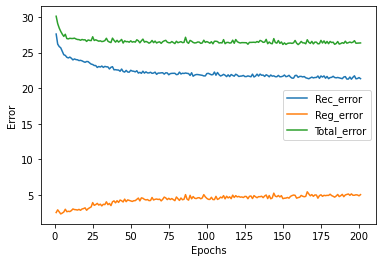

In [41]:
img_size = 8
n_in_out = img_size * img_size
n_mid = 16
n_z = 2

eta = 0.001
epochs = 201
batch_size = 32
interval = 20

digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 15
t_train = digits_data.target

middle_layer_enc = MiddleLayer(n_in_out, n_mid)
mu_layer = ParamsLayer(n_mid,  n_z)
log_var_layer = ParamsLayer(n_mid,  n_z)
z_layer = LatentLayer()

middle_layer_dec = MiddleLayer(n_z, n_mid)
output_layer = OutputLayer(n_mid, n_in_out)

def get_rec_error(y, t):
    eps = 1e-7
    return -np.sum(t*np.log(y+eps) + (1-t)*np.log(1-y+eps)) / len(y)

def get_reg_error(mu, log_var):
    return -np.sum(1 + log_var - mu**2 - np.exp(log_var)) / len(mu)

rec_error_record = []
reg_error_record = []
total_error_record = []
n_batch = len(x_train) // batch_size
for i in range(epochs):
    
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        
        forward_propagation(x_mb)
        backpropagation(x_mb)
        
        update_params()
    
    forward_propagation(x_train)
    
    rec_error = get_rec_error(output_layer.y, x_train)
    reg_error = get_reg_error(mu_layer.y, log_var_layer.y)
    total_error = rec_error + reg_error
    
    rec_error_record.append(rec_error)
    reg_error_record.append(reg_error)
    total_error_record.append(total_error)
    
    if i%interval == 0:
        print("Epoch:",i,
              "Rec_error:",rec_error,
              "Reg_error:",reg_error,
              "Total_error:",total_error)

plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

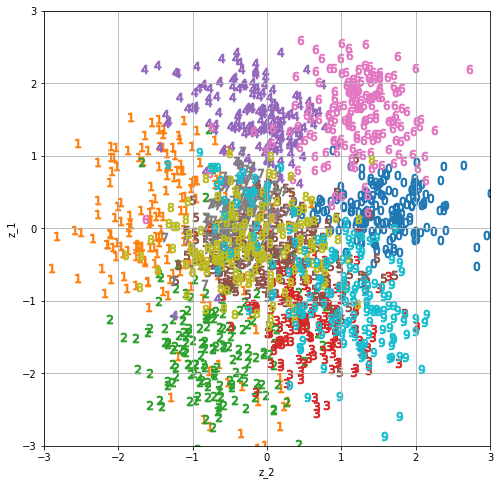

In [43]:
forward_propagation(x_train)

plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z_layer.z[t_train==i]
    z_1 = zt[:, 0]
    z_2 = zt[:, 1]
    marker = "$"+str(i)+"$"
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

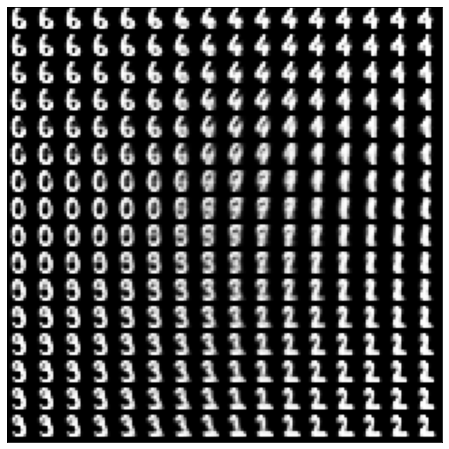

In [46]:
n_img = 16
img_size_spaced = img_size + 2

matrix_image = np.zeros((img_size_spaced*n_img,
                         img_size_spaced*n_img))

z_1 = np.linspace(3, -3, n_img)
z_2 = np.linspace(3, -3, n_img)

for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = np.array([float(z1), float(z2)])
        middle_layer_dec.forward(x)
        output_layer.forward(middle_layer_dec.y)
        image = output_layer.y.reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top:top+img_size,
                     left:left+img_size] = image
    
plt.figure(figsize=(8,8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

#### 実装(pytorch)

In [406]:
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= x_train.max()
x_train = x_train.reshape(-1, 64)
y = digits_data.target

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float64)

train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)

In [407]:
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)
    
    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        return y, z
    
    def reparameterize(self, mean, var):
        eps = torch.randn(mean.size()).to(self.device)
        z = mean + torch.sqrt(var) * eps
        return z
    
    def lower_bound(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        
        reconst =  - torch.mean(torch.sum(x * torch.log(y)
                                       + (1 - x) * torch.log(1 - y),
                                       dim=1))
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))
        
        L = reconst + kl
        
        return L

In [408]:
class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(8*8, 16)
        self.l_mean = nn.Linear(16, 2)
        self.l_var = nn.Linear(16, 2)
    
    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        mean = self.l_mean(h)
        var = self.l_var(h)
        var = F.softplus(var)
        
        return mean, var
    
class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(2, 16)
        self.l2 = nn.Linear(16, 8*8)
    
    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        y = torch.sigmoid(h)
        
        return y

In [421]:
model = VAE(device=device).to(device)
criterion = model.lower_bound
optimizer = optimizers.Adam(model.parameters(), lr=0.001)

In [422]:
epochs = 200
train_loss_record = []
for epoch in range(epochs):
    train_loss = 0.
    for (x, _) in train_dataloader:
        x = x.to(device)
        model.train()
        loss = criterion(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_loss_record.append(train_loss)
    
    if epoch%20 == 0:
        print("Epoch: {}, Loss: {:3f}".format(epoch+1, train_loss))

Epoch: 1, Loss: 41.642061
Epoch: 21, Loss: 26.127284
Epoch: 41, Loss: 25.794050
Epoch: 61, Loss: 25.562402
Epoch: 81, Loss: 25.372650
Epoch: 101, Loss: 25.178112
Epoch: 121, Loss: 25.147136
Epoch: 141, Loss: 25.065801
Epoch: 161, Loss: 25.072570
Epoch: 181, Loss: 25.038612


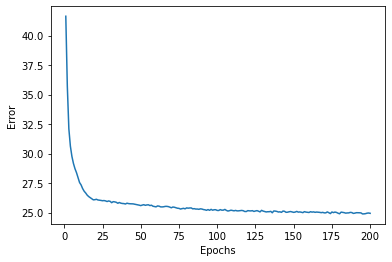

In [423]:
plt.plot(range(1, len(train_loss_record)+1), train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

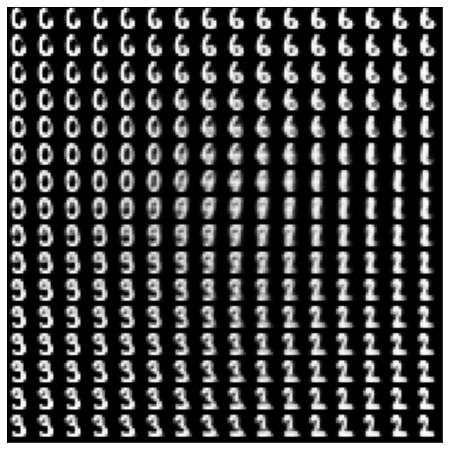

In [425]:
model.eval()

n_img = 16
img_size_spaced = img_size + 2

matrix_image = np.zeros((img_size_spaced*n_img,
                         img_size_spaced*n_img))

z_1 = np.linspace(3, -3, n_img)
z_2 = np.linspace(3, -3, n_img)


for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = torch.Tensor([float(z1), float(z2)])
        image = model.decoder(x).detach().numpy().reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top:top+img_size,
                     left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

<ipython-input-424-79d44b53393d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)


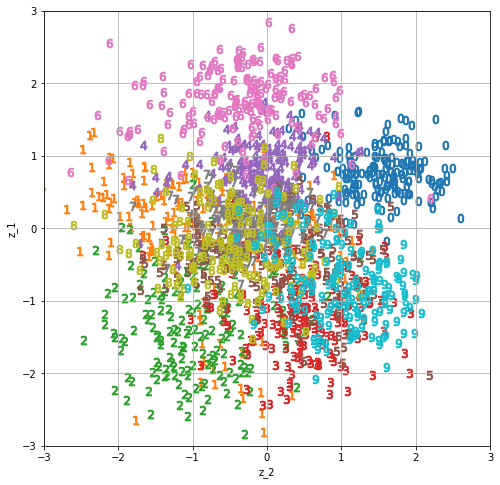

In [424]:
x_train = torch.tensor(x_train, dtype=torch.float32)

z = model.forward(x_train)[1]

plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z[t_train==i]
    z_1 = zt[:, 0]
    z_2 = zt[:, 1]
    marker = "$"+str(i)+"$"
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [848]:
from keras import backend as K
from keras.layers import Lambda
from keras import backend, metrics
import tensorflow as tf

class VAE(Model):
    def __init__(self):
        self.is_placeholder = True
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.lambda1 = Lambda(lambda x: sampling(x), output_shape=(2,))
    
    def call(self, x):
        mean_var = self.encoder(x)
        self.mean = mean_var[0]
        self.var = mean_var[1]
        z = self.lambda1(mean_var)
        y = self.decoder(z)

        xent_loss = - K.sum(x * K.log(y) + (1 - x) * K.log(1 - y), axis=1)
        kl_loss = - K.sum(1 + K.log(self.var) - K.square(self.mean) - self.var, axis=1)
        vae_loss = K.mean(xent_loss) + 0.5*K.mean(kl_loss)

        self.add_loss(vae_loss)
        return y, z

In [849]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1.)
    return z_mean + K.sqrt(z_log_var) * epsilon

class Encoder(Model):
    def __init__(self):
        super().__init__()
        self.l1 = Dense(16, activation='relu')
        self.l_mean = Dense(2)
        self.l_var = Dense(2, activation='softplus')
    
    def call(self, x):
        h = self.l1(x)
        mean = self.l_mean(h)
        var = self.l_var(h)
        
        return mean, var

class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.l1 = Dense(16, activation='relu')
        self.l2 = Dense(64, activation='sigmoid')
    
    def call(self, x):
        h = self.l1(x)
        h = self.l2(h)
        return h

In [850]:
model = VAE()
model.build((None, 1,64))  # build with input shape.
dummy_input = Input(shape=(1,64))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model.summary()

ValueError: Expected a symbolic Tensors or a callable for the loss value. Please wrap your loss computation in a zero argument `lambda`.

In [851]:
model = VAE()
model.compile(optimizer='adam')

In [852]:
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= x_train.max()

history = model.fit(x_train,
                    epochs=200,
                    batch_size=32,
                    shuffle=True)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - ETA: 0s - loss: 44.61 - ETA: 0s - loss: 43.65 - 0s 2ms/step - loss: 43.0593
Epoch 2/200
57/57 [==============================] - ETA: 0s - loss: 41.89 - ETA: 0s - loss: 40.37 - 0s 1ms/step - loss: 39.6663
Epoch 3/200
57/57 [==============================] - ETA: 0s - loss: 36.30 - ETA: 0s - loss: 35.95 - 0s 2ms/step - loss: 34.9679
Epoch 4/200
5

Epoch 119/200
57/57 [==============================] - ETA: 0s - loss: 26.15 - ETA: 0s - loss: 25.77 - 0s 1ms/step - loss: 25.6254
Epoch 120/200
57/57 [==============================] - ETA: 0s - loss: 28.34 - ETA: 0s - loss: 25.75 - 0s 1ms/step - loss: 25.7416
Epoch 121/200
57/57 [==============================] - ETA: 0s - loss: 25.75 - ETA: 0s - loss: 25.71 - 0s 1ms/step - loss: 25.7522
Epoch 122/200
57/57 [==============================] - ETA: 0s - loss: 24.15 - ETA: 0s - loss: 25.79 - 0s 1ms/step - loss: 25.7734
Epoch 123/200
57/57 [==============================] - ETA: 0s - loss: 25.91 - ETA: 0s - loss: 25.60 - 0s 1ms/step - loss: 25.5669
Epoch 124/200
57/57 [==============================] - ETA: 0s - loss: 24.01 - ETA: 0s - loss: 25.70 - 0s 1ms/step - loss: 25.7534
Epoch 125/200
57/57 [==============================] - ETA: 0s - loss: 25.55 - ETA: 0s - loss: 25.54 - 0s 1ms/step - loss: 25.6175
Epoch 126/200
57/57 [==============================] - ETA: 0s - loss: 25.48 - ETA:

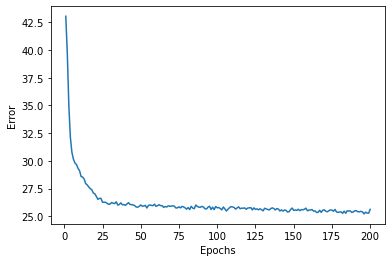

In [853]:
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



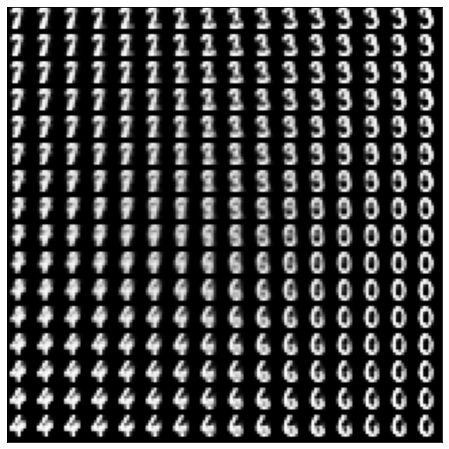

In [854]:
n_img = 16
img_size_spaced = img_size + 2

matrix_image = np.zeros((img_size_spaced*n_img,
                         img_size_spaced*n_img))

z_1 = np.linspace(3, -3, n_img)
z_2 = np.linspace(3, -3, n_img)


for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = np.float64(np.array([[z1,z2]]))
        image = np.array(model.decoder(x)).reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top:top+img_size,
                     left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



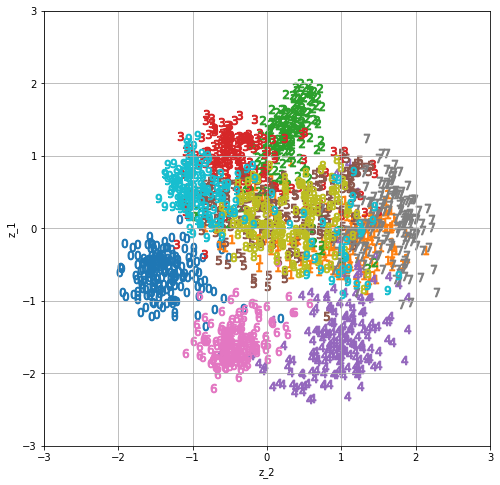

In [855]:
#x_train = torch.tensor(x_train, dtype=torch.float32)

z = model(x_train)[1]

plt.figure(figsize=(8, 8))
for i in range(10):
    zt = np.array(z[t_train==i])
    z_1 = zt[:, 0]
    z_2 = zt[:, 1]
    marker = "$"+str(i)+"$"
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [162]:
x_train.shape

torch.Size([1797, 64])

In [197]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= x_train.max()
x_train = x_train.reshape(-1,1, 8,8)
y = digits_data.target

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float64)

train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [198]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = ConvEncoder(device=device)
        self.decoder = ConvDecoder(device=device)
    
    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        return y, z
    
    def reparameterize(self, mean, var):
        eps = torch.randn(mean.size()).to(self.device)
        z = mean + torch.sqrt(var) * eps
        return z
    
    def lower_bound(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        x = x.reshape(1,-1)
        y = y.reshape(1,-1)
        
        reconst =  - torch.mean(torch.sum(x * torch.log(y)
                                       + (1 - x) * torch.log(1 - y),
                                       dim=1))
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))
        
        L = reconst + kl
        
        return L

In [199]:
class ConvEncoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.l1 = nn.Linear(32*2*2, 16)
        self.l_mean = nn.Linear(16, 2)
        self.l_var = nn.Linear(16, 2)
    
    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = h.view(h.shape[0], -1)
        h = self.l1(h)
        h = torch.relu(h)
        mean = self.l_mean(h)
        var = self.l_var(h)
        var = F.softplus(var)
        
        return mean, var
    
class ConvDecoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(2, 16)
        self.l2 = nn.Linear(16, 32*2*2)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        h = h.view(-1, 32, 2, 2)
        h = self.conv1(h)
        h = torch.relu(h)
        h = self.conv2(h)
        y = torch.sigmoid(h)
        
        return y

In [200]:
from torchsummary import summary

summary(ConvDecoder(), (1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
            Linear-2               [-1, 1, 128]           2,176
   ConvTranspose2d-3             [-1, 16, 4, 4]           8,208
   ConvTranspose2d-4              [-1, 1, 8, 8]             257
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [201]:
device = None

model = ConvVAE(device=device).to(device)
criterion = model.lower_bound
optimizer = optimizers.Adam(model.parameters(), lr=0.001)

In [202]:
epochs = 300
train_loss_record = []
for epoch in range(epochs):
    train_loss = 0.
    for (x, _) in train_dataloader:
        x = x.to(device)
        model.train()
        loss = criterion(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_loss_record.append(train_loss)
    
    if epoch%20 == 0:
        print("Epoch: {}, Loss: {:3f}".format(epoch+1, train_loss))

Epoch: 1, Loss: 2568.296117
Epoch: 21, Loss: 1481.856281
Epoch: 41, Loss: 1414.605076
Epoch: 61, Loss: 1364.740502
Epoch: 81, Loss: 1333.644137
Epoch: 101, Loss: 1316.558054
Epoch: 121, Loss: 1296.454255
Epoch: 141, Loss: 1283.198653
Epoch: 161, Loss: 1272.677508
Epoch: 181, Loss: 1266.428551
Epoch: 201, Loss: 1259.415476
Epoch: 221, Loss: 1253.145575
Epoch: 241, Loss: 1247.980244
Epoch: 261, Loss: 1244.437999
Epoch: 281, Loss: 1242.528176


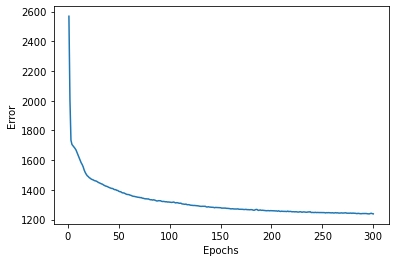

In [203]:
plt.plot(range(1, len(train_loss_record)+1), train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

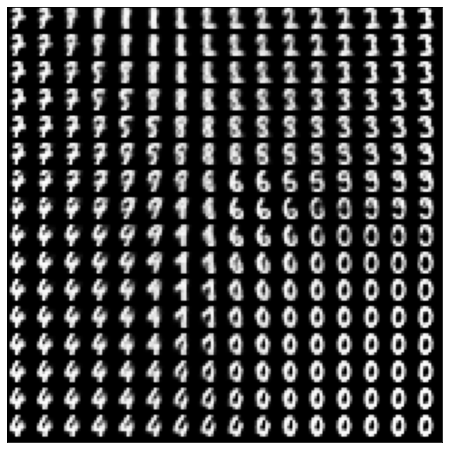

In [204]:
model.eval()

n_img = 16
img_size=8
img_size_spaced = img_size + 2

matrix_image = np.zeros((img_size_spaced*n_img,
                         img_size_spaced*n_img))

z_1 = np.linspace(3, -3, n_img)
z_2 = np.linspace(3, -3, n_img)


for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = torch.Tensor([float(z1), float(z2)])
        image = model.decoder(x).detach().numpy().reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top:top+img_size,
                     left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

<ipython-input-205-e1f07801bb34>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)


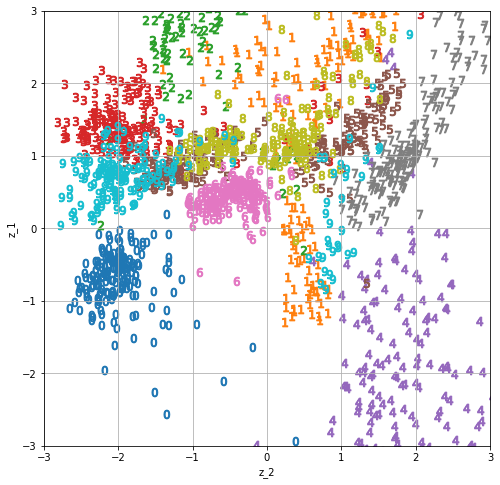

In [205]:
x_train = torch.tensor(x_train, dtype=torch.float32)

z = model.forward(x_train)[1]

plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z[y==i]
    z_1 = zt[:, 0]
    z_2 = zt[:, 1]
    marker = "$"+str(i)+"$"
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [243]:
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Flatten, Reshape, Dense, Input
from keras import backend, metrics
import tensorflow as tf

class ConvVAE(Model):
    def __init__(self):
        self.is_placeholder = True
        super().__init__()
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()
        self.lambda1 = Lambda(lambda x: sampling(x), output_shape=(2,))
    
    def call(self, x):
        mean_var = self.encoder(x)
        self.mean = mean_var[0]
        self.var = mean_var[1]
        z = self.lambda1(mean_var)
        y = self.decoder(z)
        
        x_ = Reshape((-1, 1))(x)
        y_ = Reshape((-1, 1))(y)
        xent_loss = - K.sum(x_ * K.log(y_) + (1 - x_) * K.log(1 - y_), axis=1)
        kl_loss = - K.sum(1 + K.log(self.var) - K.square(self.mean) - self.var, axis=1)
        vae_loss = K.mean(xent_loss) + 0.5*K.mean(kl_loss)

        self.add_loss(vae_loss)
        return y, z

In [244]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1.)
    return z_mean + K.sqrt(z_log_var) * epsilon

class ConvEncoder(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(16, kernel_size=3, strides=2, padding='same')
        self.conv2 = Conv2D(32, kernel_size=3, strides=2, padding='same')
        self.flat = Flatten()
        self.l1 = Dense(16, activation='relu')
        self.l_mean = Dense(2)
        self.l_var = Dense(2, activation='softplus')
    
    def call(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.flat(h)
        h = self.l1(h)
        mean = self.l_mean(h)
        var = self.l_var(h)
        
        return mean, var

class ConvDecoder(Model):
    def __init__(self):
        super().__init__()
        self.l1 = Dense(16, activation='relu')
        self.l2 = Dense(32*2*2, activation='relu')
        self.reshape = Reshape((2, 2, 32))
        self.conv1 = Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv2 = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')
    
    def call(self, x):
        h = self.l1(x)
        h = self.l2(h)
        h = self.reshape(h)
        h = self.conv1(h)
        h = self.conv2(h)
        return h

In [245]:
model = ConvEncoder()
model.build((None, 8,8,1))  # build with input shape.
dummy_input = Input(shape=(8,8,1))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model.summary()

Model: "conv_encoder_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 4, 4, 16)          160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 32)          4640      
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 34        
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 34        
Total params: 6,932
Trainable params: 6,932
Non-trainable params: 0
__________________________________________________

In [246]:
model = ConvVAE()
model.compile(optimizer='adam')

In [247]:
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= x_train.max()
x_train = x_train.reshape(-1,8,8,1)

history = model.fit(x_train,
                    epochs=200,
                    batch_size=32,
                    shuffle=True)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - ETA: 0s - loss: 44.71 - ETA: 1s - loss: 44.60 - ETA: 0s - loss: 44.30 - ETA: 0s - loss: 44.01 - ETA: 0s - loss: 43.75 - ETA: 0s - loss: 43.71 - ETA: 0s - loss: 43.42 - 0s 6ms/step - loss: 42.9530
Epoch 2/200
57/57 [==============================] - ETA: 0s - loss: 39.86 - ETA: 0s - loss: 39.99 - ETA: 0s - loss: 39.15 - ETA: 0s - loss: 38.79 - ET

57/57 [==============================] - ETA: 0s - loss: 27.17 - ETA: 0s - loss: 26.47 - ETA: 0s - loss: 26.37 - ETA: 0s - loss: 26.23 - ETA: 0s - loss: 26.20 - ETA: 0s - loss: 26.11 - 0s 5ms/step - loss: 26.1978
Epoch 26/200
57/57 [==============================] - ETA: 0s - loss: 25.16 - ETA: 0s - loss: 26.37 - ETA: 0s - loss: 26.32 - ETA: 0s - loss: 26.42 - ETA: 0s - loss: 26.36 - ETA: 0s - loss: 26.38 - ETA: 0s - loss: 26.31 - ETA: 0s - loss: 26.33 - ETA: 0s - loss: 26.25 - 0s 8ms/step - loss: 26.2656
Epoch 27/200
57/57 [==============================] - ETA: 0s - loss: 27.53 - ETA: 0s - loss: 26.37 - ETA: 0s - loss: 26.32 - ETA: 0s - loss: 26.49 - ETA: 0s - loss: 26.45 - ETA: 0s - loss: 26.36 - ETA: 0s - loss: 26.28 - ETA: 0s - loss: 26.24 - ETA: 0s - loss: 26.18 - ETA: 0s - loss: 26.24 - ETA: 0s - loss: 26.18 - 1s 10ms/step - loss: 26.2205
Epoch 28/200
57/57 [==============================] - ETA: 0s - loss: 24.86 - ETA: 0s - loss: 26.70 - ETA: 0s - loss: 26.57 - ETA: 0s - loss: 

57/57 [==============================] - ETA: 0s - loss: 24.71 - ETA: 0s - loss: 25.33 - ETA: 0s - loss: 25.58 - ETA: 0s - loss: 25.59 - ETA: 0s - loss: 25.57 - ETA: 0s - loss: 25.67 - 0s 5ms/step - loss: 25.6491
Epoch 55/200
57/57 [==============================] - ETA: 0s - loss: 26.06 - ETA: 0s - loss: 25.58 - ETA: 0s - loss: 25.48 - ETA: 0s - loss: 25.37 - ETA: 0s - loss: 25.39 - ETA: 0s - loss: 25.33 - ETA: 0s - loss: 25.27 - ETA: 0s - loss: 25.27 - 0s 7ms/step - loss: 25.3692
Epoch 56/200
57/57 [==============================] - ETA: 0s - loss: 25.15 - ETA: 0s - loss: 25.76 - ETA: 0s - loss: 25.55 - ETA: 0s - loss: 25.55 - ETA: 0s - loss: 25.49 - ETA: 0s - loss: 25.43 - ETA: 0s - loss: 25.44 - 0s 6ms/step - loss: 25.4468
Epoch 57/200
57/57 [==============================] - ETA: 0s - loss: 26.85 - ETA: 0s - loss: 25.71 - ETA: 0s - loss: 25.60 - ETA: 0s - loss: 25.50 - ETA: 0s - loss: 25.50 - ETA: 0s - loss: 25.51 - 0s 5ms/step - loss: 25.5232
Epoch 58/200
57/57 [=================

57/57 [==============================] - ETA: 0s - loss: 25.06 - ETA: 0s - loss: 25.36 - ETA: 0s - loss: 25.00 - ETA: 0s - loss: 24.87 - ETA: 0s - loss: 24.96 - ETA: 0s - loss: 25.08 - ETA: 0s - loss: 25.10 - ETA: 0s - loss: 25.15 - ETA: 0s - loss: 25.12 - ETA: 0s - loss: 25.13 - ETA: 0s - loss: 25.07 - 1s 10ms/step - loss: 25.0530
Epoch 87/200
57/57 [==============================] - ETA: 0s - loss: 28.27 - ETA: 0s - loss: 24.72 - ETA: 0s - loss: 24.94 - ETA: 0s - loss: 25.08 - ETA: 0s - loss: 25.14 - ETA: 0s - loss: 24.99 - ETA: 0s - loss: 25.04 - ETA: 0s - loss: 24.98 - ETA: 0s - loss: 24.96 - ETA: 0s - loss: 25.02 - ETA: 0s - loss: 24.96 - 1s 10ms/step - loss: 25.0061
Epoch 88/200
57/57 [==============================] - ETA: 0s - loss: 24.39 - ETA: 0s - loss: 25.42 - ETA: 0s - loss: 25.29 - ETA: 0s - loss: 25.20 - ETA: 0s - loss: 25.12 - ETA: 0s - loss: 25.05 - ETA: 0s - loss: 25.12 - ETA: 0s - loss: 25.07 - ETA: 0s - loss: 24.97 - 0s 8ms/step - loss: 25.0007
Epoch 89/200
57/57 [=

57/57 [==============================] - ETA: 0s - loss: 24.60 - ETA: 0s - loss: 24.56 - ETA: 0s - loss: 24.96 - ETA: 0s - loss: 24.75 - ETA: 0s - loss: 24.98 - ETA: 0s - loss: 24.85 - ETA: 0s - loss: 24.80 - ETA: 0s - loss: 24.84 - ETA: 0s - loss: 24.84 - ETA: 0s - loss: 24.83 - ETA: 0s - loss: 24.83 - 1s 10ms/step - loss: 24.8542
Epoch 116/200
57/57 [==============================] - ETA: 0s - loss: 24.42 - ETA: 0s - loss: 24.68 - ETA: 0s - loss: 24.68 - ETA: 0s - loss: 24.62 - ETA: 0s - loss: 24.80 - ETA: 0s - loss: 24.81 - 0s 5ms/step - loss: 24.8339
Epoch 117/200
57/57 [==============================] - ETA: 0s - loss: 24.86 - ETA: 0s - loss: 24.93 - ETA: 0s - loss: 24.80 - ETA: 0s - loss: 24.81 - ETA: 0s - loss: 24.83 - ETA: 0s - loss: 24.88 - 0s 5ms/step - loss: 24.8678
Epoch 118/200
57/57 [==============================] - ETA: 0s - loss: 26.13 - ETA: 0s - loss: 25.21 - ETA: 0s - loss: 24.93 - ETA: 0s - loss: 24.87 - ETA: 0s - loss: 24.85 - ETA: 0s - loss: 24.79 - ETA: 0s - los

57/57 [==============================] - ETA: 0s - loss: 24.26 - ETA: 0s - loss: 24.79 - ETA: 0s - loss: 24.75 - ETA: 0s - loss: 24.60 - ETA: 0s - loss: 24.59 - ETA: 0s - loss: 24.54 - 0s 5ms/step - loss: 24.5391
Epoch 148/200
57/57 [==============================] - ETA: 0s - loss: 27.96 - ETA: 0s - loss: 24.93 - ETA: 0s - loss: 25.39 - ETA: 0s - loss: 25.30 - ETA: 0s - loss: 25.19 - ETA: 0s - loss: 25.11 - 0s 5ms/step - loss: 25.0684
Epoch 149/200
57/57 [==============================] - ETA: 0s - loss: 28.59 - ETA: 0s - loss: 25.11 - ETA: 0s - loss: 25.04 - ETA: 0s - loss: 24.97 - ETA: 0s - loss: 24.77 - ETA: 0s - loss: 24.86 - ETA: 0s - loss: 24.92 - ETA: 0s - loss: 24.85 - 0s 7ms/step - loss: 24.8703
Epoch 150/200
57/57 [==============================] - ETA: 0s - loss: 25.54 - ETA: 0s - loss: 24.70 - ETA: 0s - loss: 24.66 - ETA: 0s - loss: 24.78 - ETA: 0s - loss: 24.64 - ETA: 0s - loss: 24.60 - ETA: 0s - loss: 24.49 - ETA: 0s - loss: 24.62 - ETA: 0s - loss: 24.62 - ETA: 0s - loss

57/57 [==============================] - ETA: 0s - loss: 24.32 - ETA: 0s - loss: 24.47 - ETA: 0s - loss: 24.59 - ETA: 0s - loss: 24.52 - ETA: 0s - loss: 24.51 - ETA: 0s - loss: 24.67 - ETA: 0s - loss: 24.63 - ETA: 0s - loss: 24.72 - ETA: 0s - loss: 24.66 - ETA: 0s - loss: 24.61 - 1s 9ms/step - loss: 24.6179
Epoch 175/200
57/57 [==============================] - ETA: 0s - loss: 24.05 - ETA: 0s - loss: 24.63 - ETA: 0s - loss: 24.55 - ETA: 0s - loss: 24.77 - ETA: 0s - loss: 24.79 - ETA: 0s - loss: 24.82 - ETA: 0s - loss: 24.79 - ETA: 0s - loss: 24.83 - ETA: 0s - loss: 24.80 - ETA: 0s - loss: 24.74 - 1s 9ms/step - loss: 24.7488
Epoch 176/200
57/57 [==============================] - ETA: 0s - loss: 26.21 - ETA: 0s - loss: 24.66 - ETA: 0s - loss: 24.41 - ETA: 0s - loss: 24.75 - ETA: 0s - loss: 24.85 - ETA: 0s - loss: 24.94 - ETA: 0s - loss: 24.92 - ETA: 0s - loss: 24.89 - ETA: 0s - loss: 24.86 - ETA: 0s - loss: 24.87 - ETA: 0s - loss: 24.86 - 1s 10ms/step - loss: 24.8630
Epoch 177/200
57/57 

Epoch 199/200
57/57 [==============================] - ETA: 0s - loss: 23.71 - ETA: 0s - loss: 24.17 - ETA: 0s - loss: 24.48 - ETA: 0s - loss: 24.81 - ETA: 0s - loss: 24.84 - ETA: 0s - loss: 24.89 - ETA: 0s - loss: 24.87 - ETA: 0s - loss: 24.82 - ETA: 0s - loss: 24.76 - ETA: 0s - loss: 24.81 - 1s 9ms/step - loss: 24.7705
Epoch 200/200
57/57 [==============================] - ETA: 0s - loss: 24.96 - ETA: 0s - loss: 24.86 - ETA: 0s - loss: 24.86 - ETA: 0s - loss: 24.85 - ETA: 0s - loss: 24.64 - ETA: 0s - loss: 24.76 - ETA: 0s - loss: 24.71 - ETA: 0s - loss: 24.74 - ETA: 0s - loss: 24.80 - ETA: 0s - loss: 24.70 - 1s 9ms/step - loss: 24.5883


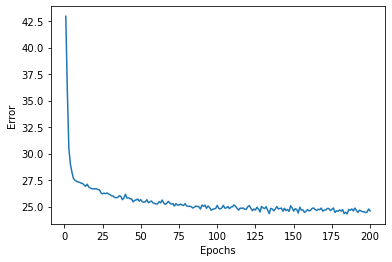

In [248]:
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



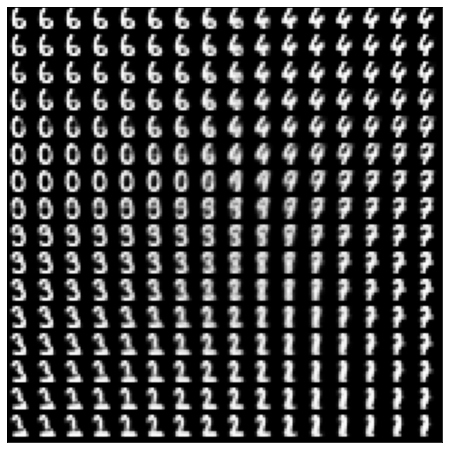

In [249]:
n_img = 16
img_size_spaced = img_size + 2

matrix_image = np.zeros((img_size_spaced*n_img,
                         img_size_spaced*n_img))

z_1 = np.linspace(3, -3, n_img)
z_2 = np.linspace(3, -3, n_img)


for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = np.float64(np.array([[z1,z2]]))
        image = np.array(model.decoder(x)).reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top:top+img_size,
                     left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

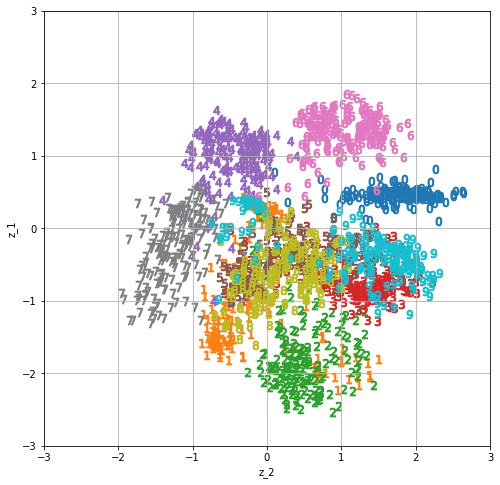

In [252]:
#x_train = torch.tensor(x_train, dtype=torch.float32)

z = model(x_train)[1]

plt.figure(figsize=(8, 8))
for i in range(10):
    zt = np.array(z[y==i])
    z_1 = zt[:, 0]
    z_2 = zt[:, 1]
    marker = "$"+str(i)+"$"
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [251]:
z

<tf.Tensor: shape=(1797, 2), dtype=float32, numpy=
array([[ 0.52533513,  1.0255377 ],
       [-0.8860265 , -0.72765607],
       [-0.5428613 , -0.59637654],
       ...,
       [-0.22089176, -0.5324756 ],
       [ 0.05802697,  0.28502932],
       [-0.33851513,  0.17695221]], dtype=float32)>